# Evaluación y Uso de ViT-Large para detección de pólipos

## Introducción

En este notebook, exploramos y evaluamos el rendimiento del modelo [ViT-Large](https://pprp.github.io/timm/models/vision-transformer/)
para la detección de pólipos cancerosos en imágen médica de colonoscopias.

Para ello utilizaremos el dataset de [**Piccolo**](https://huggingface.co/hustvl/yolos-base) combinado en entrenamiento con el dataset [CVC](https://polyp.grand-challenge.org/CVCClinicDB/),
este conjunto de datasets proporciona imágenes de colonoscopias tanto en RGB como en NBI,
y combinar ambos en entrenamiento nos dará mas variedad y cacapidad de generalización.
Para la detección **modificaremos el modelo** el modelo para detectar los pólipos
usando bboxes.

### Problema

Ya estudiadas una serie de arquitecturas hemos llegado a un problema, las arquitecturars ViT no generalizan correctamente, y no conseguimos **resultados mayores de 50% en validación**.

**La hipótesis** es que las arquitecturas no sean capaces de mejorar debido a que **los patrones son muy compolejos**, y es posible que **un modelo con más parámetros** sea capaz de mejorar esos resultados.

### Objetivos

- Modificar el modelo **ViT-Large** para la detección de pópipos con bounding boxes.
- Entrenar el modelo con las imágenes medicas seleccionadas haciendo un **fine-tunning** para imágen médica.
- Mostar el rendimiento del mismo con el benchamark del modelo seleccionado

¡Comencemos con la evaluación del modelo!
## Pasos a seguir

1. Cargamos y analizamos los **datasets**
2. **Procesamos los datos** para cumplir con el formato de entrada del modelo
3. Cargamos y **modificamos el modelo** para detección de pólipos
4. **Entrenamos** el modelo con los datos obtenidos
4. **Evaluamos** el rendimiento

### 1- Cargar y analizar el dataset

Como hemos mencionado cargaremos el datset de [**Piccolo**](https://www.biobancovasco.bioef.eus/en/Sample-and-data-catalog/Databases/PD178-PICCOLO-EN.html),
el cuál tiene una cantidad rezonable de imágenes en RGB y NBI categorizadas por 
al pólipo al que pertenecen por lo que podemos usar la división pre hecha del dataset
y evitar asignar frames del mismo pólipo al train y validation invalidando los relustados.

Además usaremos el dataset [CVC](https://polyp.grand-challenge.org/CVCClinicDB/)
para enriquecer a Piccolo en entrenamiento y evitar que generalice mal

Además mostraré informaciñon relevante de las imágenes escogidas

In [1]:
import sys
import os

path_to_add = os.path.abspath('../../utils')
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

from utils import ImageDatasetProcessor as idp
from utils import graph_utils

DS_PATH = "../../datasets"
DS_NAME = "Piccolo+CVC"
json_path = f"{DS_PATH}/piccolo_dataset/{DS_NAME}_dict.json"

# paths del dataset
paths_img = [
    # train paths
    (DS_PATH + "/piccolo_dataset/test/polyps",                      # polyps
     DS_PATH + "/piccolo_dataset/test/masks",                       # masks
     DS_PATH + "/piccolo_dataset/test/void", "test"  ,              # voids
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),      # light type

    # test paths
    (DS_PATH + "/piccolo_dataset/train/polyps",
     DS_PATH + "/piccolo_dataset/train/masks",
     DS_PATH + "/piccolo_dataset/train/void", "train",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # cvc train path
    (DS_PATH + "/CVC-ClinicDB/polyps", 
     DS_PATH + "/CVC-ClinicDB/masks",
     None, "train", None),

    # validation paths
    (DS_PATH + "/piccolo_dataset/validation/polyps",
     DS_PATH + "/piccolo_dataset/validation/masks",
     DS_PATH + "/piccolo_dataset/validation/void", "validation",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv")]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_Piccolo = idp(target_resolution=(400, 240), dataset_name=DS_NAME,
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_Piccolo.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada. Y señalar que usaremos la división del propio dataset,
 es decir, usaremos el split base de train, test y validation ya que este es 
 **distribuye los pólipos** no las imagenes aleatoriamente,
 **evitando tener imágenes del mismo pólipo en train y validation**, añadiremos 
 al conjunto base de train las imágenes del dataset CVC

In [2]:
dt_Piccolo.print_summary()

Total imágenes: 4045
Composición del dataset:
Resoluciónes: total distintas resoluciones 3
	480x854: 1972	1080x1920: 1461	288x384: 612

Tipos de luz:
	WL: 2131	NBI: 1302	Unknown: 612

Splits:
	test: 333	train: 2815	validation: 897

Canales:
	polyp_RGB: 4045	mask_L: 4045	void_L: 3433

Volumen medio de los pólipos respecto a la imagen:	18.52638097233012%
Volumen medio de las bbox respecto a la imagen:	25.46564466476527%
Distancia media del centro del pólipos al centro de la imagen:	56.5451833276923px


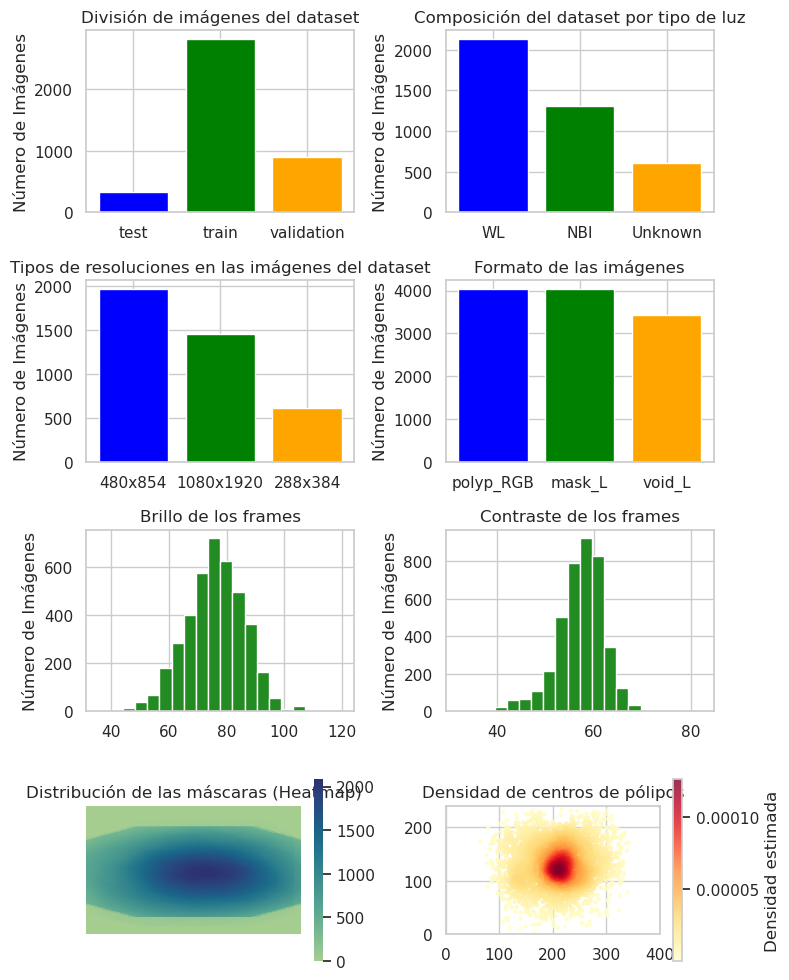

In [3]:
dt_Piccolo.graph_summary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

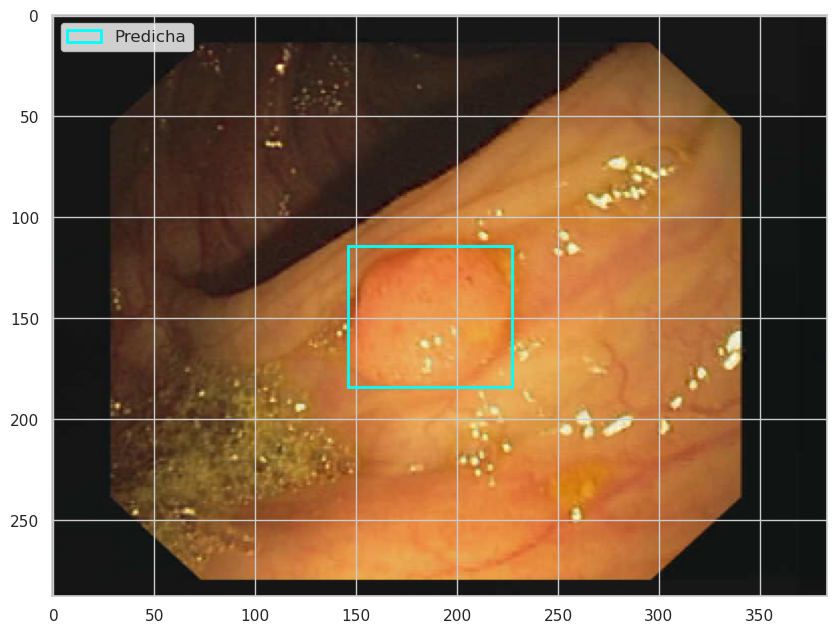

In [4]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_Piccolo.dict.keys()))
dt_Piccolo.show_image(rand_key)


## Entrenamiento de ViT-Large

Para esta segunda entrenaremos el modelo de [ViT-Large](https://pprp.github.io/timm/models/vision-transformer/) **de la librería timm**,
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para entrenar y devolver tan solo las bboxes ya que 
ViT-Large ofrece la arquitectura del encoder ViT por lo que **añadiremos un head de detección**, en este caso una **MLP**, que devuelva las bboxes 

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante

In [5]:
from transformers import YolosForObjectDetection
import torch.nn as nn
import torch

# Creamos una cabeza de deteccion siguiendo el formato de YOLO
class BBoxMLP(nn.Module):
    def __init__(self, in_features=1024, hidden_dim=384, out_features=4):
        super(BBoxMLP, self).__init__()
        
        # Creamos la MLP de detección
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_dim),     # capa de entrada
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),      # capa intermedia
            nn.ReLU(),
            nn.Linear(hidden_dim, out_features)     # capa de salida
        )

    # debemos definir el forward ya que heredamos de nn.Module
    def forward(self, x):
        return self.mlp(x)  # ejecuta la sentencia de mlp

# Modificamos la arquitectura ViT-small para detectar con la cabeza BBoxMLP
class ViTs4Detection(nn.Module):
    # Usamos el constructor original pero eliminando la MLP de clasificación
    # Esto evita que el modelo actualize en el backward esa MLP
    def __init__(self, vit_model, bbox_head):
        super(ViTs4Detection, self).__init__()  # iniciamos la clase padre antes de nada
        
        self.vit = vit_model
        self.head_bbox = bbox_head

    def forward(self, x):
        # x es la entrada de la imagen
        features = self.vit(x)      # ejecutamos la vit
        # forma de salida (batch_size, 384) -> ya tenemos los CLS
        bboxes = self.head_bbox(features)

        return {'pred_bboxes': bboxes}

#### Preparar el entrenamiento
Una vez modificado el modelo solo debemos preparar el entrenamiento, es decir:
- Definir los dataloders
- Cargar el modelo personaliazdo
- Definir las funciones de pérdida y optimizadores
- Definir una fuinciñon de entrenamiento

Utilizaremos el **optimizador Adalain** ya que es el usado en Yolos-base y la 
**loss fuction smooth_l1_loss** para las bbox de la salida ya que es información contínua

In [6]:
import timm
import torch.nn as nn

# Cargamos el modelo de la librería timm
vit_S = timm.create_model('vit_large_patch16_384', pretrained=True, num_classes=0)

# creamos el modelo con la cabeza personalizada de detección
model = ViTs4Detection(vit_S, BBoxMLP())
model.train()

ViTs4Detection(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_feature

#### Entrenamiento

Ahora por fin pasamos a entrenar el modelo y recopilar los dátos de análisis 
para ellos obtenemos el IoU de las bboxes, ya que al ser areas en al imágen no 
podemos medir un "accuracy" tal cual.

**IoU** es una métrica usada para este
tipo de situaciones en las que se calcula: **IoU=Area_interseccion/Area_union** 
por lo que es importante tener en cuenta que **un IoU 1 es una coincidencia exacta**



Resumen TRAIN:
Total imágenes: 2815
Composición del dataset:
Resoluciónes: total distintas resoluciones 3
	480x854: 1288	1080x1920: 915	288x384: 612

Tipos de luz:
	WL: 1382	NBI: 821	Unknown: 612

Splits:
	train: 2815

Canales:
	polyp_RGB: 2815	mask_L: 2815	void_L: 2203

Volumen medio de los pólipos respecto a la imagen:	15.87968505601612%
Volumen medio de las bbox respecto a la imagen:	22.467608779659017%
Distancia media del centro del pólipos al centro de la imagen:	58.09527935775687px


Resumen VALIDATION:
Total imágenes: 897
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 351	1080x1920: 546

Tipos de luz:
	WL: 557	NBI: 340

Splits:
	validation: 897

Canales:
	polyp_RGB: 897	mask_L: 897	void_L: 897

Volumen medio de los pólipos respecto a la imagen:	28.716799907314865%
Volumen medio de las bbox respecto a la imagen:	37.44927428567616%
Distancia media del centro del pólipos al centro de la imagen:	52.60287435330402px


Resumen TEST:
Total imágenes: 3

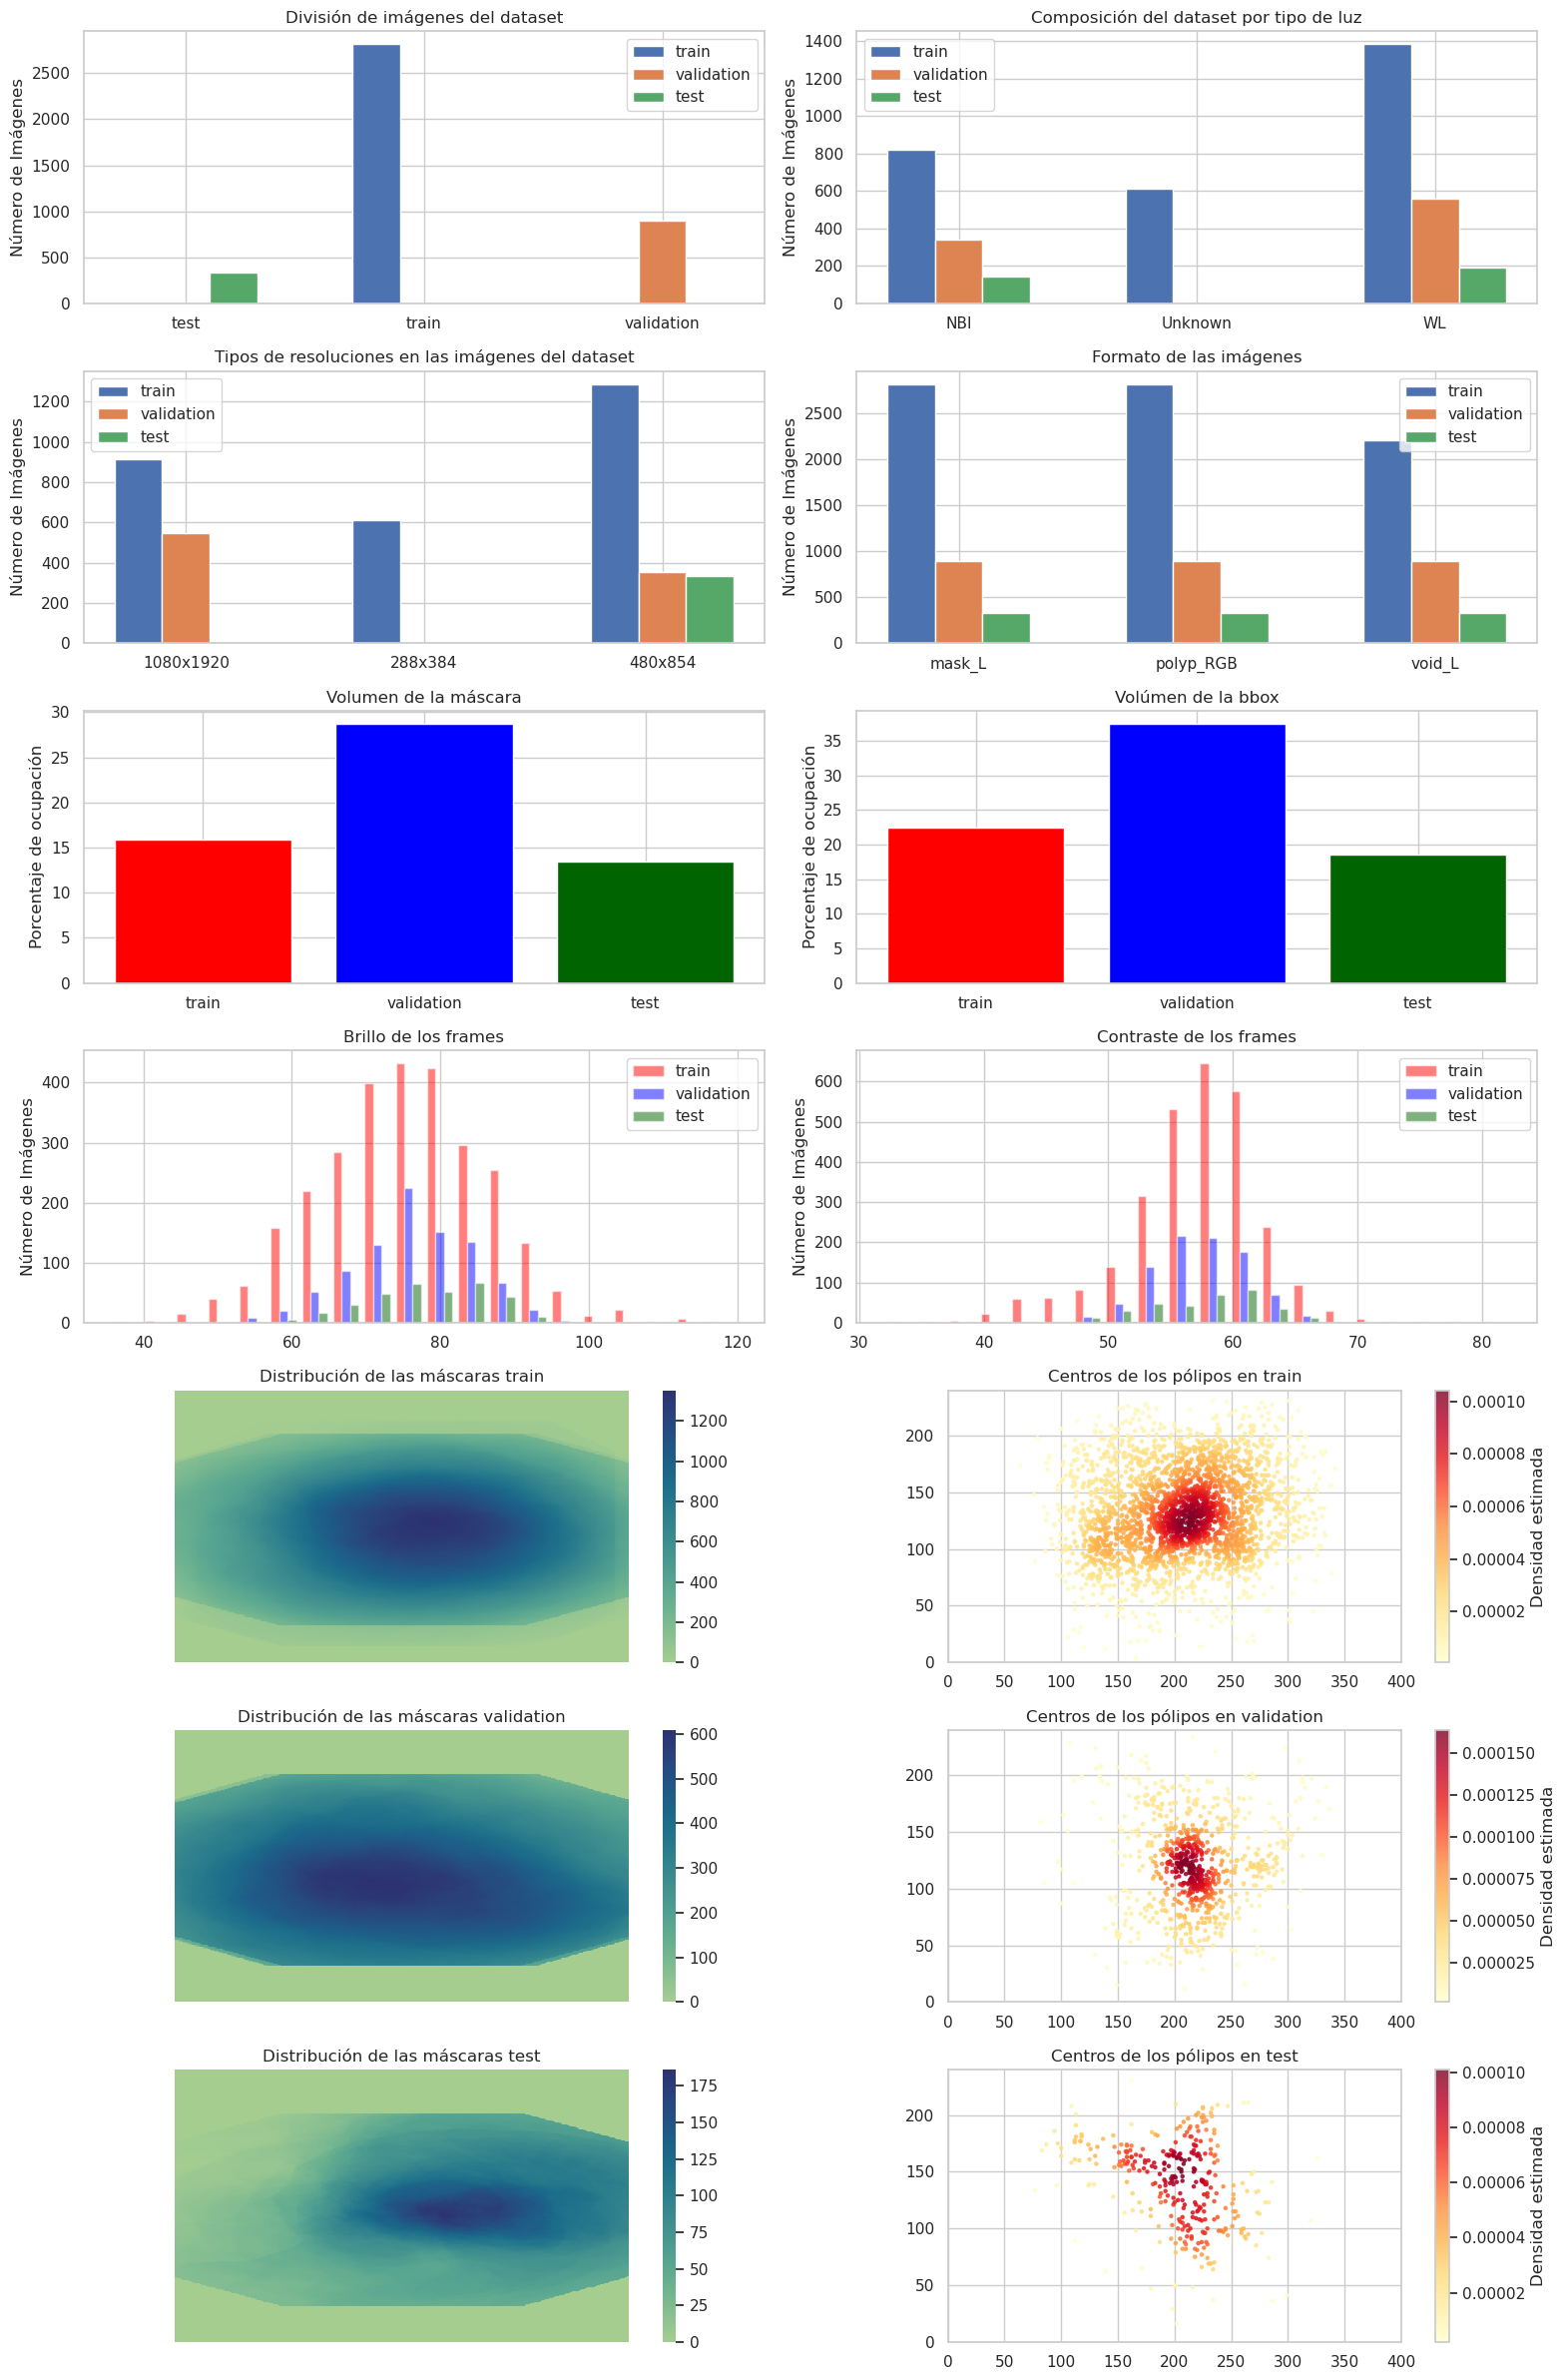

In [7]:
from utils import TrainModel as trm
from torch.optim import AdamW
import json

# definimos los parametros del entrenamiento 🏃‍♂
MODEL_NAME = "ViT-Large"
NUM_EPOCH = 20              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_RES = (384, 384)      # 📷 Resolucion entreno
EVAL_NAME = "_post_train_eval"
RESULTS_JSON = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}{EVAL_NAME}.json"
RESULTS_IMG = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}{EVAL_NAME}.png"
json_exists = False     # flag para comprobar si tnemos un json

# Obtener los diccionarios con formato de entrenamiento y mostramos sus carcterísticas
train_loader, val_loader, test_loader = dt_Piccolo.get_dataloaders(
                                            BATCH_SIZE, 
                                            use_premade_splits=True,
                                            analize_splits=True)

In [8]:
# definimos el optimizador y la loss function
def loss_fn(target, pred):
    return nn.functional.smooth_l1_loss(pred, target)

optimizer = AdamW(model.parameters(), lr=5e-5)
trainer = trm(model, loss_fn=loss_fn, optim=optimizer, eval_pred=True)

# si ya tenemos los resulados no volvemos a entrenar
if os.path.isfile(RESULTS_JSON):
    with open(RESULTS_JSON, "r", encoding="utf-8") as json_file:
            train_results = json.load(json_file)
    json_exists = True

if not json_exists:
    train_results = trainer.train_model(NUM_EPOCH, TRAIN_RES,
                                    train_loader, val_loader, test_loader)
    # guardamos los datos
    with open(RESULTS_JSON, "w", encoding="utf-8") as json_file:
        json.dump(train_results, json_file)  # `indent=4` para formato legible

Entrenando en GPU 1


Epoch 0  Loss train 0.0009  IoU train 0.4005 
Epoch 0  Loss valid 0.0013  IoU valid 0.5226 
Epoch 1  Loss train 0.0003  IoU train 0.5702 
Epoch 1  Loss valid 0.0012  IoU valid 0.4873 
Epoch 2  Loss train 0.0002  IoU train 0.6412 
Epoch 2  Loss valid 0.0014  IoU valid 0.4590 
Epoch 3  Loss train 0.0001  IoU train 0.6760 
Epoch 3  Loss valid 0.0011  IoU valid 0.5105 
Epoch 4  Loss train 0.0001  IoU train 0.7025 
Epoch 4  Loss valid 0.0011  IoU valid 0.5594 
Epoch 5  Loss train 0.0001  IoU train 0.6909 
Epoch 5  Loss valid 0.0013  IoU valid 0.5003 
Epoch 6  Loss train 0.0002  IoU train 0.6283 
Epoch 6  Loss valid 0.0010  IoU valid 0.5347 
Epoch 7  Loss train 0.0001  IoU train 0.6597 
Epoch 7  Loss valid 0.0012  IoU valid 0.5192 
Epoch 8  Loss train 0.0001  IoU train 0.7049 
Epoch 8  Loss valid 0.0011  IoU valid 0.5745 
Epoch 9  Loss train 0.0001  IoU train 0.7390 
Epoch 9  Loss valid 0.0011  IoU valid 0.5388 
Epoch 10  Loss train 0.0000  IoU train 0.7679 
Epoch 10  Loss valid 0.0010  IoU 

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

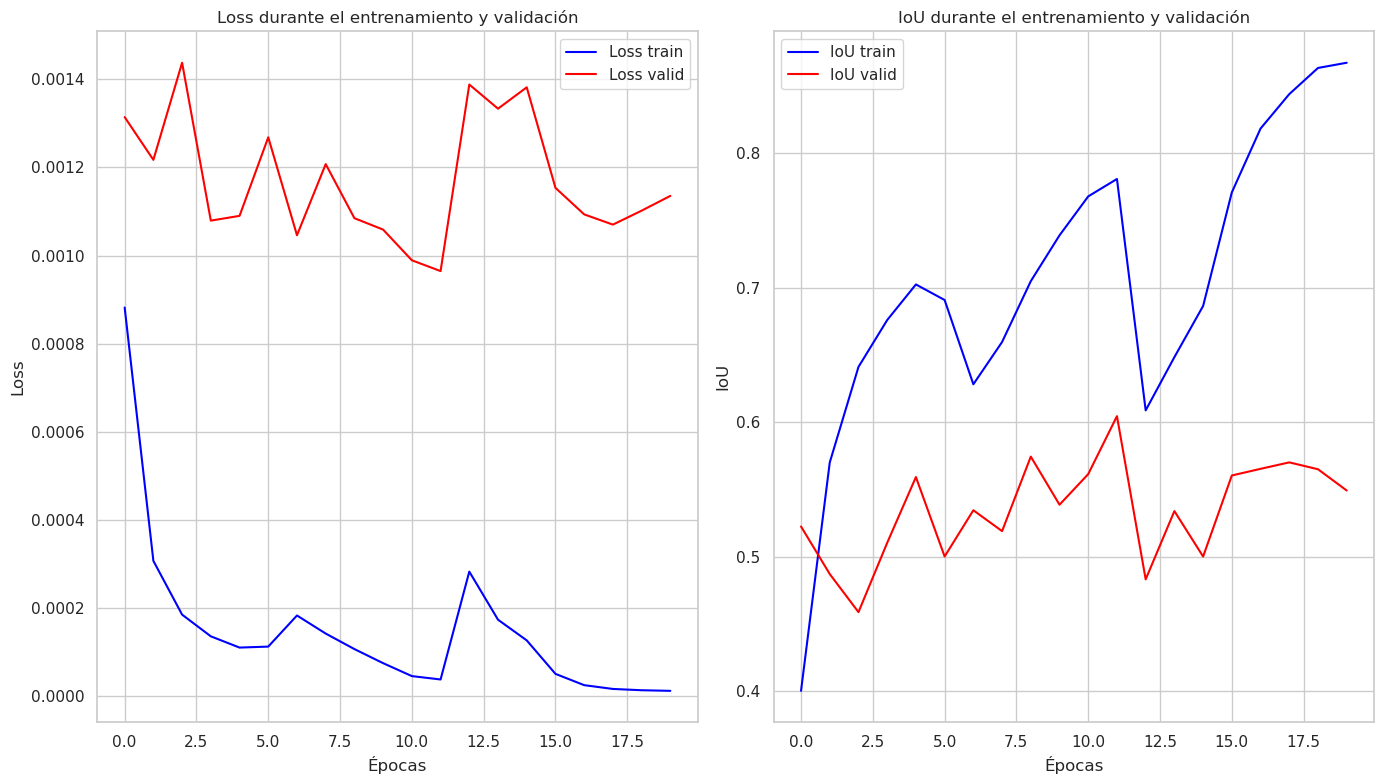

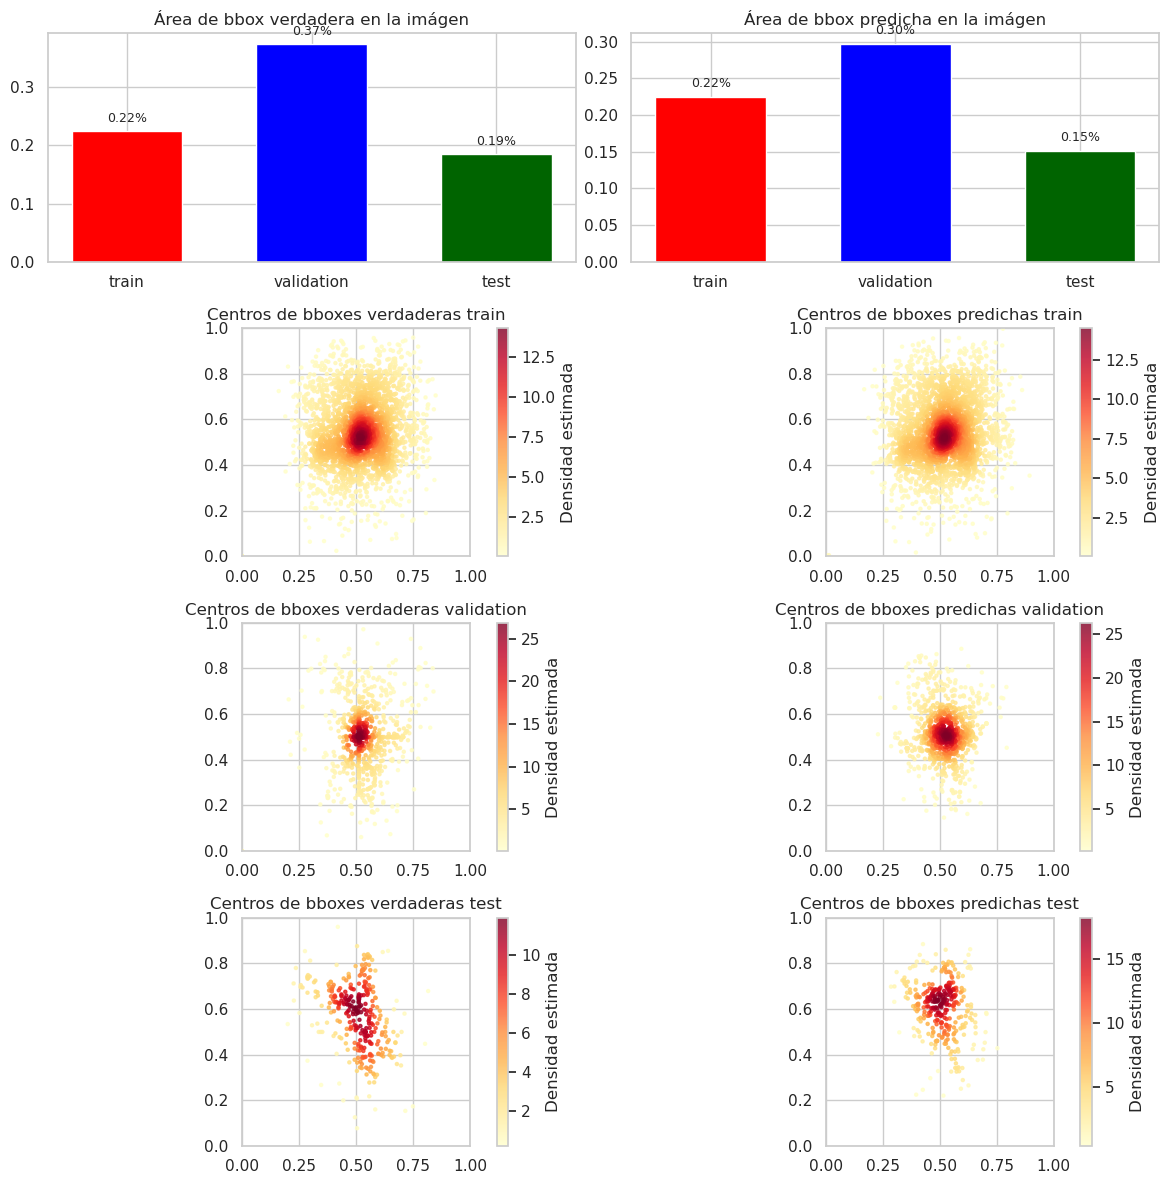

End of training!
-------------------- FINAL RESULTS ------------------------
|     - Test loss:	0.000554                      |
|     - Test IoU:	0.509                        |
-----------------------------------------------------------


In [9]:
trainer.show_results(train_results, save_img=True, img_name=RESULTS_IMG)

Ahora mostramos algunos de los **resultados del entrenamiento**

1070


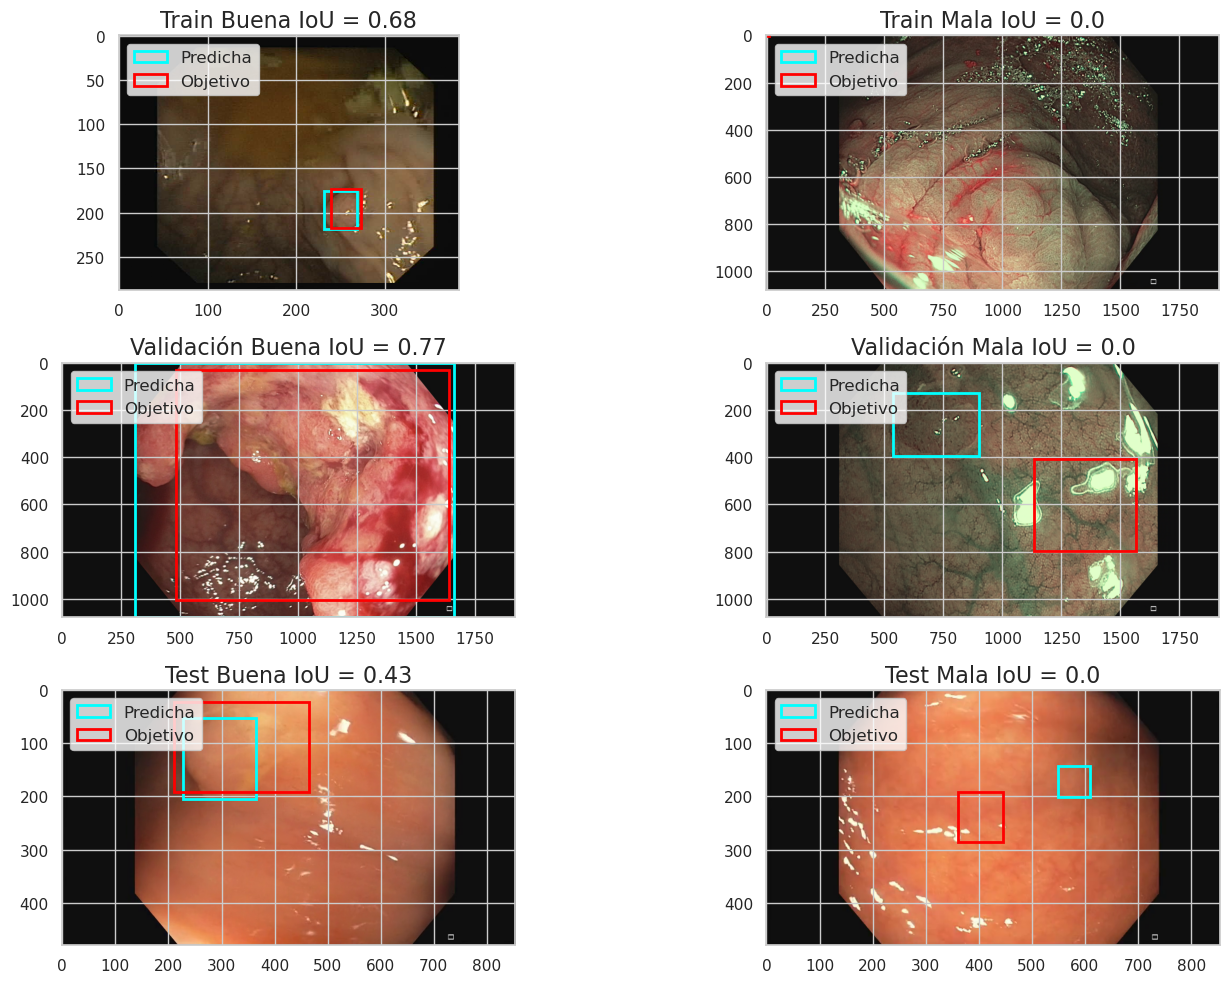

In [10]:
import matplotlib.pyplot as plt

train_data, val_data, test_data = train_results["eval_data"]

num_rows = 3
num_cols = 2

# Creamos la figura con un número adecuado de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

IoU_up_th = 0.4
IoU_down_th = 0.4

# train (buena, mala), validación (buena, mala), test (buena, mala)
selected_ids = [[0, 0], [0, 0], [0, 0]]

# seleccionamos una imagen con buen resultado y mal resultado de cada spit
for i, split_data in enumerate(train_results["eval_data"]):
    found_img = False
    # seleccionamos una imaǵen con buen resultado
    while not found_img:
        id = random.randint(0, len(split_data)-1)
        if split_data[id]["IoU"] > IoU_up_th:
            selected_ids[i][0] = id
            found_img = True

    # seleccionamos una imaǵen con mal resultado
    found_img = False
    while not found_img:
        id = random.randint(0, len(split_data)-1)
        if split_data[id]["IoU"] < IoU_down_th:
            selected_ids[i][1] = id
            found_img = True
            

print(selected_ids[0][0])
img_names = ["Train Buena", "Train Mala", 
             "Validación Buena", "Validación Mala", 
             "Test Buena", "Test Mala"]

for i, split_ids in enumerate(selected_ids):
    for j, id in enumerate(split_ids):
        if i == 0:  # Train
            eval_dict = train_data[id]
        elif i == 1:  # Validación
            eval_dict = val_data[id]
        else:  # Test
            eval_dict = test_data[id]

        # Llamamos a la función para mostrar la imagen
        graph_utils.show_image(eval_dict["image_path"], eval_dict["true_bbox"], 
                               pred_bbox=eval_dict["pred_bbox"], 
                               name=f"{img_names[i*2 + j]} IoU = {eval_dict["IoU"]:.2}",
                               ax=axes[i, j])

plt.tight_layout()

# Mostramos el mosaico de imágenes
plt.show()